In [9]:
import os
import logging
import pandas as pd

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the paths to your datasets
train_uc_set = '/home/jovyan/vol-1/crema-d-train'
val_uc_set = '/home/jovyan/vol-1/crema-d-val'
test_uc_set = '/home/jovyan/vol-1/crema-d-test'

# Define the emotion labels from the file names
uc_label2id = {'ANG': 0, 'HAP': 1, 'NEU': 2, 'DIS': 3, 'FEA': 4, 'SAD': 5}

# Function to count emotion classes in a directory
def count_emotion_classes(folder_path):
    class_counts = {emotion: 0 for emotion in uc_label2id.keys()}
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mp4'):
            emotion = file_name.split('_')[2]  # Extract emotion class from filename
            if emotion in class_counts:
                class_counts[emotion] += 1

    return class_counts

# Count emotion classes in each dataset folder
train_counts = count_emotion_classes(train_uc_set)
val_counts = count_emotion_classes(val_uc_set)
test_counts = count_emotion_classes(test_uc_set)

# Log the results
logging.info(f"Emotion class counts in training set: {train_counts}")
logging.info(f"Emotion class counts in validation set: {val_counts}")
logging.info(f"Emotion class counts in test set: {test_counts}")


2024-10-29 15:53:44,818 - INFO - Emotion class counts in training set: {'ANG': 243, 'HAP': 243, 'NEU': 243, 'DIS': 243, 'FEA': 243, 'SAD': 243}
2024-10-29 15:53:44,818 - INFO - Emotion class counts in validation set: {'ANG': 81, 'HAP': 81, 'NEU': 81, 'DIS': 81, 'FEA': 81, 'SAD': 81}
2024-10-29 15:53:44,819 - INFO - Emotion class counts in test set: {'ANG': 81, 'HAP': 81, 'NEU': 81, 'DIS': 81, 'FEA': 81, 'SAD': 81}


In [10]:
import os
import shutil
import random
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define paths and emotion labels
train_uc_set = '/home/jovyan/vol-1/crema-d-train'
val_uc_set = '/home/jovyan/vol-1/crema-d-val'
test_uc_set = '/home/jovyan/vol-1/crema-d-test'
uc_label2id = {'ANG': 0, 'HAP': 1, 'NEU': 2, 'DIS': 3, 'FEA': 4, 'SAD': 5}

# Function to balance emotion classes in a directory
def balance_emotion_classes(folder_path):
    # Count emotion classes in the folder
    emotion_files = {emotion: [] for emotion in uc_label2id.keys()}
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mp4'):
            emotion = file_name.split('_')[2]
            if emotion in emotion_files:
                emotion_files[emotion].append(file_name)
    
    # Find the minimum class count
    min_count = min(len(files) for files in emotion_files.values())
    
    # Down-sample each emotion class to the minimum count
    for emotion, files in emotion_files.items():
        if len(files) > min_count:
            files_to_remove = random.sample(files, len(files) - min_count)
            for file_name in files_to_remove:
                file_path = os.path.join(folder_path, file_name)
                os.remove(file_path)
    
    logging.info(f"Balanced emotion classes in {folder_path} to {min_count} per class.")

# Apply balance to train, val, and test sets
balance_emotion_classes(train_uc_set)
balance_emotion_classes(val_uc_set)
balance_emotion_classes(test_uc_set)


2024-10-29 15:53:47,568 - INFO - Balanced emotion classes in /home/jovyan/vol-1/crema-d-train to 243 per class.
2024-10-29 15:53:47,569 - INFO - Balanced emotion classes in /home/jovyan/vol-1/crema-d-val to 81 per class.
2024-10-29 15:53:47,570 - INFO - Balanced emotion classes in /home/jovyan/vol-1/crema-d-test to 81 per class.


In [15]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  # Declare batch size

# Setup complete, now ready to process video data
train_uc_set = '/home/jovyan/vol-1/crema-d-train'
val_uc_set = '/home/jovyan/vol-1/crema-d-val'
test_uc_set = '/home/jovyan/vol-1/crema-d-test'

# Define the emotion labels from the file names
uc_label2id = {'ANG': 0, 'HAP': 1, 'NEU': 2, 'DIS': 3, 'FEA': 4, 'SAD': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}


import pandas as pd

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[2]  # Extract emotion class from filename
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  # Change to float32
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  # Set the correct shape
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)

# Create a custom Keras layer to wrap the pre-trained model
class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = TFSMLayer(pretrained_model)(inputs)

    # Define the output layer
    outputs = layers.Dense(len(uc_label2id), dtype='float32', activation=None)(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  # Reduced learning rate to avoid OOM issues
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

# Print the summary of the model to verify the structure
model.summary()

# Training without jit_scope
history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-10-29 15:54:31,741 - INFO - Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer_1 (TFSMLayer)    (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 2406      
                                                                 
Total params: 2406 (9.40 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-10-29 15:54:45.517903: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1458
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:772"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

Epoch 1/50
364/364 [==============================] - ETA: 0s - loss: 1.7627 - acc@1: 0.2418 - acc: 0.6374

2024-10-29 15:57:59.391668: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 486
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:777"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
    

364/364 [==============================] - 267s 690ms/step - loss: 1.7627 - acc@1: 0.2418 - acc: 0.6374 - val_loss: 1.6588 - val_acc@1: 0.2748 - val_acc: 0.6860
Epoch 2/50
364/364 [==============================] - 247s 676ms/step - loss: 1.5824 - acc@1: 0.3441 - acc: 0.7576 - val_loss: 1.5627 - val_acc@1: 0.3388 - val_acc: 0.7727
Epoch 3/50
364/364 [==============================] - 243s 665ms/step - loss: 1.5087 - acc@1: 0.3949 - acc: 0.7837 - val_loss: 1.5296 - val_acc@1: 0.3884 - val_acc: 0.7603
Epoch 4/50
364/364 [==============================] - 247s 676ms/step - loss: 1.4584 - acc@1: 0.4087 - acc: 0.8015 - val_loss: 1.4891 - val_acc@1: 0.4153 - val_acc: 0.7831
Epoch 5/50
364/364 [==============================] - 246s 673ms/step - loss: 1.4379 - acc@1: 0.4231 - acc: 0.8022 - val_loss: 1.5304 - val_acc@1: 0.3698 - val_acc: 0.7851
Epoch 6/50
364/364 [==============================] - 250s 679ms/step - loss: 1.4125 - acc@1: 0.4327 - acc: 0.8139 - val_loss: 1.4824 - val_acc@1: 0.39

In [16]:
from sklearn.metrics import classification_report


evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")



2024-10-30 08:25:35.078462: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 486
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:781"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
    

121/121 [==============================] - 71s 576ms/step - loss: 1.2263 - acc@1: 0.5227 - acc: 0.8616
Accuracy: 0.8615702390670776
Top-3 Accuracy: 0.5227272510528564


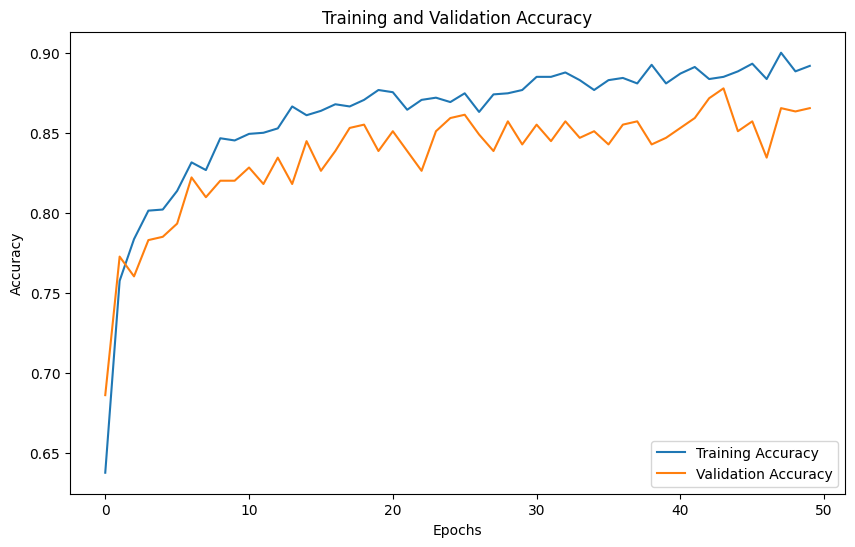

1/1 [==============================] - 0s 113ms/step


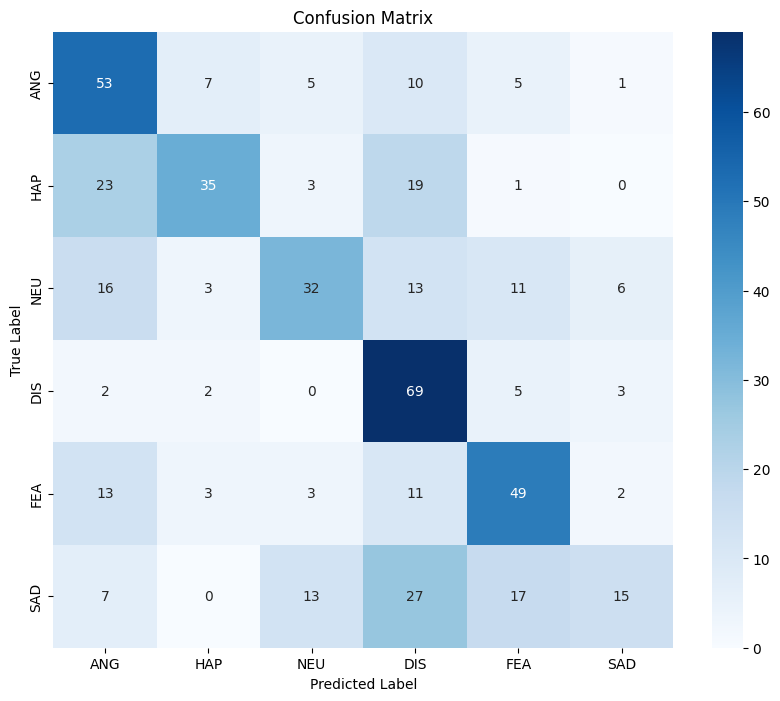

Classification Report:
               precision    recall  f1-score   support

         ANG       0.46      0.65      0.54        81
         HAP       0.70      0.43      0.53        81
         NEU       0.57      0.40      0.47        81
         DIS       0.46      0.85      0.60        81
         FEA       0.56      0.60      0.58        81
         SAD       0.56      0.19      0.28        79

    accuracy                           0.52       484
   macro avg       0.55      0.52      0.50       484
weighted avg       0.55      0.52      0.50       484



In [22]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming `uc_id2label` dictionary from previous code
emotion_labels = list(uc_id2label.values())

def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

# Plot accuracy
plot_accuracy(history)

def evaluate_model_metrics(model, dataset, label_mapping):
    # Generate predictions
    y_true = []
    y_pred = []
    
    for videos, labels in dataset:
        predictions = model.predict(videos)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=list(label_mapping.keys()))
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title("Confusion Matrix")
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=list(label_mapping.keys()))
    print("Classification Report:\n", report)

# Call the function to evaluate metrics and plot the confusion matrix
evaluate_model_metrics(model, test_uc_ds, uc_label2id)


In [23]:
model.save('/home/jovyan/vol-1/saved_model_oncremad', save_format='tf')


2024-10-30 08:52:57,380 - INFO - Assets written to: /home/jovyan/vol-1/saved_model_oncremad/assets


In [24]:
import os
import numpy as np
import tensorflow as tf
from decord import VideoReader

# Define the input size and number of frames
input_size = 224
num_frame = 16

# Load the saved model from the specified folder
model_path = '/home/jovyan/vol-1/saved_model_oncremad'
model = tf.keras.models.load_model(model_path)

# Function to read and format video
def read_video(file_path):
    """Read and format video from the given file path."""
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    """Format frames by converting to float and resizing."""
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path):
    """Load a video and convert it to a tensor."""
    video = read_video(file_path)
    video = tf.convert_to_tensor(video, dtype=tf.float32)
    video = tf.expand_dims(video, axis=0)  # Add batch dimension
    return video

# Path to the test video
test_video_path = '/home/jovyan/vol-1/crema-d-test/1001_IOM_HAP_XX.mp4'

# Load and process the video
video_tensor = load_video(test_video_path)

# Perform prediction
predictions = model.predict(video_tensor)
predicted_class = np.argmax(predictions, axis=-1)[0]

# Mapping class ID back to emotion label
uc_id2label = {0: 'ANG', 1: 'HAP', 2: 'NEU', 3: 'DIS', 4: 'FEA', 5: 'SAD'}

predicted_emotion = uc_id2label[predicted_class]

# Output the predicted emotion class
print(f'Predicted emotion class: {predicted_emotion}')


1/1 [==============================] - 7s 7s/step
Predicted emotion class: HAP
